In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Dataset generation

First we need to generate the dataset used for the training. We do this using the AFM simulation code Probe Particle Model from Prokop Hapala et al. 

The Probe Particle Model does not have a python package so we need to manually download the repository from github. We will use a specific branch and commit in order to make sure that the results are replicatable.
```console
git clone https://github.com/ProkopHapala/ProbeParticleModel.git
cd ProbeParticleModel
git checkout 7f162d0cfe034b352b2280f31f6a5f8e19d83693
```
Take note of the directory where you saved the repository and set the path to the variable `PPMdir` below.

In order for ProbeParticleModel to run correctly we need to tell pyopencl where to find nvidia drivers. On Linux within a conda environment, the following should work:
```console
cp /etc/OpenCL/vendors/nvidia.icd $CONDA_PREFIX'/etc/OpenCL/vendors/'
```

We also need the molecule geometries that the AFM simulation takes as an input. Download these from here: https://www.dropbox.com/s/n5cn6pafjzavehc/Molecules_xyz3.tar?dl=0. Extract the archive and set the path of the directory to the variable `Moldir` below.

Set the path to the directory where you want to save the dataset to the variable `save_dir`. __Note: the full dataset takes about ~250GB of space.__

Choose the dataset that you want to generate by setting the variable `dataset` to either `'light'` or `'heavy'`. The words light and heavy do not refer to the sizes of the datasets but rather the atomic elements which they contain. The light dataset contains only the elements H, C, N, O, and F, and the heavy dataset additionally contains Si, P, S, Cl, and Br.

In [2]:
PPMdir = './ProbeParticleModel/'    # Path to the ProbeParticleModel repository
Moldir = './Molecules3/'            # Path to the molecule geometry files
dataset = 'light'                   # Or 'heavy'. Which dataset to generate
data_dir = './Data_%s/' % dataset   # Directory where to save data

Next we set all the options for the data generator.

In [3]:
# Generator options
gen_args = {
    'PPMdir'            : PPMdir,       # Probe Particle Model repository directory
    'preName'           : Moldir,       # Molecules are read from filename = preName + molecules[imol] + postName
    'postName'          : '.xyz',
    'Ymode'             : 'D-S-H',      # Generator descriptor output mode
    'batch_size'        : 30,           # Batch size
    'nBestRotations'    : 30,           # Number of rotations for each molecule
    'distAbove'         : 5.0,          # Distance between the scan start height and highest atom in the scan
    'distAboveDelta'    : 0.25,         # Random variation range(+-) for distAbove
    'scan_dim'          : (128,128,20), # Scan size (voxels), final z-size = scan_dim[2]-df_weight_steps (df_weight_steps = 10 by default)
    'iZPPs'             : [8],          # Probe particle(s) (8=O, 54=Xe)
    'Qs'                : [-0.1],       # Probe particle charges
    'tip_type'          : 'monopole',   # Tip electrostatics model (monopole, dipole, quadrupole)
    'maxTilt0'          : 0.5,
    'diskMode'          : 'sphere',
    'dzmax'             : 1.2,
    'dzmax_s'           : 1.2
}

# Molecules
if dataset == 'light':
    N_train        = 5000      # Number of training molecules from light molecule set
    N_val          = 1500      # Number of validation molecules from light molecule set
    N_test         = 2500      # Number of test molecules from light molecule set
    N_train_h      = 0         # Number of training molecules from heavy molecule set
    N_val_h        = 0         # Number of validation molecules from heavy molecule set
    N_test_h       = 0         # Number of test molecules from heavy molecule set
elif dataset == 'heavy':
    N_train        = 3500
    N_val          = 900
    N_test         = 1200
    N_train_h      = 2500
    N_val_h        = 600
    N_test_h       = 1200
else:
    raise ValueError('Invalid dataset')

# Heavy molecules
train_molecules = ['heavy/'+str(n) for n in range(N_train_h)]
val_molecules = ['heavy/'+str(n) for n in range(N_train_h,N_train_h+N_val_h)]
test_molecules = ['heavy/'+str(n) for n in range(N_train_h+N_val_h,N_train_h+N_val_h+N_test_h)]

# Light molecules
train_molecules += ['light/'+str(n) for n in range(N_train)]
val_molecules += ['light/'+str(n) for n in range(N_train,N_train+N_val)]
test_molecules += ['light/'+str(n) for n in range(N_train+N_val,N_train+N_val+N_test)]

# Make sure save directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Now we generate the dataset. This will take at least half an hour (GTX 1080 + NVMe SSD), probably more depending on your GPU and your storage device.

In [4]:
from data_generation import construct_generator

# Generate dataset
start_time = time.time()
counter = 1
total_len = len(train_molecules)+len(val_molecules)+len(test_molecules)
for mode, molecules in zip(['train', 'val', 'test'], [train_molecules, val_molecules, test_molecules]):

    # Make generator
    gen = construct_generator(molecules=molecules, **gen_args)

    # Make sure target directory exists
    target_dir = data_dir+mode+'/'
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Generate batches
    for i in range(len(gen)):
        batch = gen.next()
        np.savez(target_dir+'batch_%d.npz'%i, batch[0].astype(np.float32), batch[1].astype(np.float32))
        eta = (time.time() - start_time)/counter * (total_len - counter)
        print('Generated %s batch %d/%d - ETA: %ds' % (mode, i+1, len(gen), eta))
        counter += 1

print('Total time taken: %d' % (time.time() - start_time))

# Model training

Now that we have generated the dataset, it is time to train the model. First we set some options and define the model architecture. The `loss_weights` parameter controls how much weight the optimization algorithm puts on the losses from the different output descriptors. The set values are something we found through empirical testing.

In [5]:
loss_weights      = [20.0, 0.2, 0.1]                              # Weights for balancing the loss
epochs            = 50                                            # How many epochs to train
pred_batches      = 3                                             # How many batches to do predictions on
model_dir         = './model_%s/' % dataset                       # Directory where all output files are saved to
pred_dir          = os.path.join(model_dir, 'predictions/')       # Where to save predictions
checkpoint_dir    = os.path.join(model_dir, 'checkpoints/')       # Where to save model checkpoints
log_path          = os.path.join(model_dir, 'training.log')       # Where to save loss history during training
history_plot_path = os.path.join(model_dir, 'loss_history.png')   # Where to plot loss history during training
descriptors       = ['Atomic_Disks', 'vdW_Spheres', 'Height_Map'] # Used for outputting information

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Create an instance of the model and compile it. We use the Adam optimizer and mean squared error. See the file `models.py` for the model definition.

In [6]:
from keras import optimizers
from models import create_model

model = create_model(last_relu=[False, True, True], out_labels=descriptors)
optimizer = optimizers.Adam(lr=0.001, decay=1e-5)
model.compile(optimizer, 'mse', loss_weights=loss_weights)
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 10) 0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 10, 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_reflective_1 (Model)     (None, 128, 128, 10, 112         reshape_1[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128, 128, 10, 0           conv3d_reflective_1[1][0]        
__________________________________________________________________________________________________
average_po

Setup data loading. The dataset is way too big to fit in memory on most systems so we need to use data generator that loads the batches from disk. We need one data generator for the training, one for the validation, and one for testing. The `DataGenerator` class will automatically read the saved batches in the directories we specify. We also define some callbacks to save information during training.

In [7]:
from data_utils import DataGenerator

train_gen = DataGenerator(os.path.join(data_dir, 'train/'))
val_gen   = DataGenerator(os.path.join(data_dir, 'val/'))
test_gen  = DataGenerator(os.path.join(data_dir, 'test/'))

In [8]:
from keras.callbacks import ModelCheckpoint, CSVLogger
from data_utils import HistoryPlotter
checkpointer = ModelCheckpoint(checkpoint_dir+'weights_{epoch:d}.h5', save_weights_only=True)
logger = CSVLogger(log_path, append=True)
plotter = HistoryPlotter(log_path, history_plot_path, descriptors)

Since the training takes a long time, it might be necessary to resume the training later. The below code will load the latest checkpoint if there are any.

In [9]:
# Resume previous epoch if exists
init_epoch = 0
model_file = None
for i in range(1, epochs+1):
    cp_file = os.path.join(checkpoint_dir, 'weights_%d.h5' % i)
    if os.path.exists(cp_file):
        init_epoch += 1
        model_file = cp_file
    else:
        break
if init_epoch > 0:
    model.load_weights(model_file)
    print('Model weights loaded from '+cp_file)

## Model fitting
Now we fit the model. __Expect this to take a long time__, on the order of a full day. You can follow the loss curve during training in the file specified in `history_plot_path`. The resulting loss curves should look similar to the ones in Figure S10 for the corresponding dataset, in the supplementary information of the paper.

Epoch 1/5
50/50 [==============================] - 14s 275ms/step - loss: 0.0318 - Atomic_Disks_loss: 9.8682e-04 - vdW_Spheres_loss: 0.0233 - Height_Map_loss: 0.0744 - val_loss: 0.0236 - val_Atomic_Disks_loss: 8.9668e-04 - val_vdW_Spheres_loss: 0.0146 - val_Height_Map_loss: 0.0278
Epoch 2/5
50/50 [==============================] - 10s 210ms/step - loss: 0.0236 - Atomic_Disks_loss: 8.8609e-04 - vdW_Spheres_loss: 0.0147 - Height_Map_loss: 0.0296 - val_loss: 0.0196 - val_Atomic_Disks_loss: 7.3324e-04 - val_vdW_Spheres_loss: 0.0134 - val_Height_Map_loss: 0.0223
Epoch 3/5
50/50 [==============================] - 11s 210ms/step - loss: 0.0216 - Atomic_Disks_loss: 8.1969e-04 - vdW_Spheres_loss: 0.0134 - Height_Map_loss: 0.0250 - val_loss: 0.0185 - val_Atomic_Disks_loss: 6.9896e-04 - val_vdW_Spheres_loss: 0.0121 - val_Height_Map_loss: 0.0209
Epoch 4/5
50/50 [==============================] - 11s 211ms/step - loss: 0.0205 - Atomic_Disks_loss: 7.7842e-04 - vdW_Spheres_loss: 0.0125 - Height_Map_l

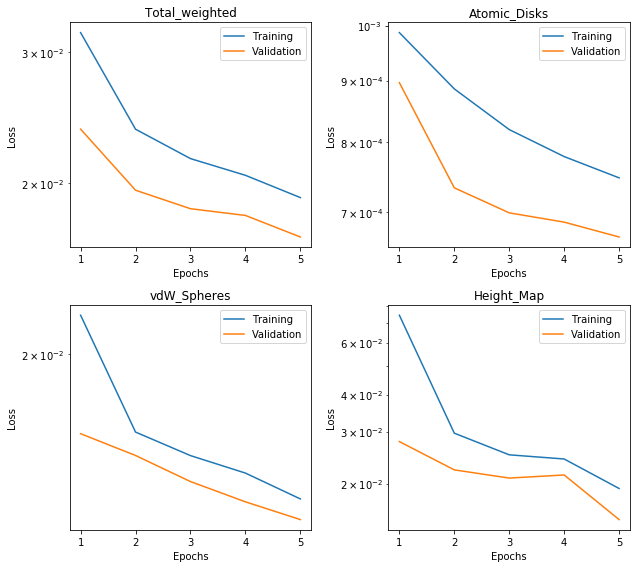

In [10]:
# Fit model
model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    initial_epoch=init_epoch,
    callbacks=[checkpointer, logger, plotter]
)

# Save final weights
model.save_weights(os.path.join(model_dir, 'model.h5'))

# Show loss history
plotter.plot(show=True)

## Model evalutation
Test the model on the test set. This should take roughly half as long as one epoch during training. The final losses should be roughly the same on the training, validation and test sets.

In [11]:
test_loss = model.evaluate_generator(test_gen, verbose=1)
print('Losses on training set: '+str(plotter.losses[-1]))
print('Losses on validation set: '+str(plotter.val_losses[-1]))
print('Losses on test set: '+str(test_loss))

25/25 [==============================] - 4s 147ms/step
Losses on training set: [0.019138563349843027, 0.000747361226240173, 0.011329500079154968, 0.019254388231784107]
Losses on validation set: [0.016948929180701573, 0.0006674173753708601, 0.010448767989873885, 0.01510827870418628]
Losses on test set: [0.01766964502632618, 0.0007084938697516918, 0.010149875804781914, 0.014697925709187985]


Finally, make some predictions on the samples in the test set. The printed files are saved to the directory specified in `pred_dir`.

Prediction saved to ./model_light/predictions/0_pred.png
Prediction saved to ./model_light/predictions/1_pred.png
Prediction saved to ./model_light/predictions/2_pred.png
Prediction saved to ./model_light/predictions/3_pred.png
Prediction saved to ./model_light/predictions/4_pred.png
Prediction saved to ./model_light/predictions/5_pred.png
Prediction saved to ./model_light/predictions/6_pred.png
Prediction saved to ./model_light/predictions/7_pred.png


KeyboardInterrupt: 

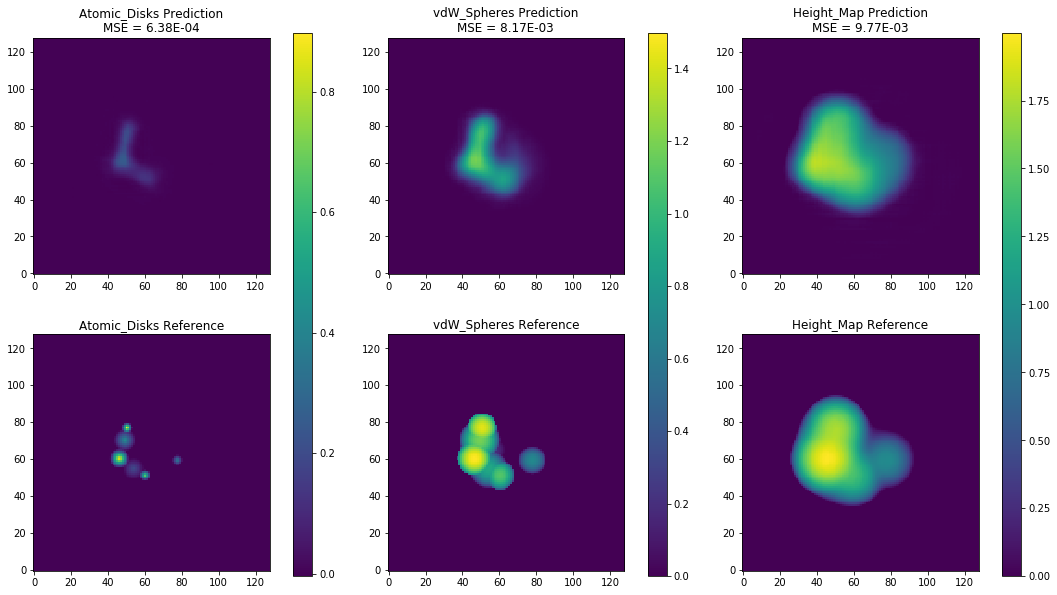

In [12]:
from data_utils import make_prediction_plots, make_input_plots, calculate_losses

for i in range(pred_batches):
    X, true = test_gen[i]
    preds = model.predict_on_batch(X)
    losses = calculate_losses(model, true, preds)
    make_prediction_plots(preds, true, losses, descriptors, pred_dir, start_ind=gen_args['batch_size']*i)
    make_input_plots(X, pred_dir, start_ind=gen_args['batch_size']*i, constant_range=False)